In [190]:
"""
Convole script:

1) Read data from all 7 sectors
2) Split up into chunks based on cmd line input
3) Write partial results
4) If time, make faster
tess_dir="/home/ctaiudovicic/projects/tess_batman/sampleData/"
# tess_dir="/home/cjtu/projects/tess_batman/sampleData/"
batman_dir="/home/ctaiudovicic/projects/tess_batman/data/"
sector=0
start=5
end=15
output_dir= "/home/ctaiudovicic/projects/tess_batman/data/tmp/"
verbosity=0
"""
!python convolve.py ~/projects/tess_batman/sampleData/ ~/projects/tess_batman/data/ 0 0 2 ~/projects/tess_batman/data/tmp/

===START TCONVOLVE===
Reading TESS data...
Found 2 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...
Convolved 2560 curves in 1.21 s
Found: 10 fitting curves
Writing table: candidates_s0_b0_e2_HD_1397_b.fits.csv
Finished TESS file in 1.22 s
Starting TESS file: HD_202772_A_b.fits
Starting convolutions...
Convolved 2560 curves in 1.18 s
Found: 10 fitting curves
Writing table: candidates_s0_b0_e2_HD_202772_A_b.fits.csv
Finished TESS file in 1.2 s
Convolved 2/2 tess files with 2560 curves in 2.62 s
===END TCONVOLVE===


In [14]:
import time
import glob
import os.path as p
import multiprocessing as mp
import numpy as np
from scipy.signal import fftconvolve
from astropy.io import ascii, fits
from astropy.table import Table, Column

def convolve(curves):
    """For parallel"""
    peak_times = np.zeros(len(curves))
    peak_convs = np.zeros(len(curves))
    for i,curve in enumerate(curves):
        batman_curve = batmanCurves[curve]
        conv = np.abs(fftconvolve(tess_flux, batman_curve, 'same'))
        ind_max = np.argmax(conv)
        peak_times[i] = tess_time[ind_max]
        peak_convs[i] = conv[idxs]

    # Return top 10
    idxs = peak_convs.argsort()[-10:]
    return peak_times[idxs], peak_convs[idxs]


def tconvolve(tess_dir, batman_dir, batman_suffix, sector, start, end, output_dir, nprocs, chunks, verbosity=0):
    """
    
    Parameters
    ----------
    tess_dir(str): directory to TESS data
    batman_dir (str): directory to model data
    batman_suffix(str): suffix to append to barmanCurves file (e.g. _small)
    sector (int): sector to pull data from
    start (int): file to start at
    end (int): file to end at
    output_dir (str): directory to write candidates.csv
    """
    
    tconv_start = time.time()
    print("===START TCONVOLVE===",flush=True)
    
    # Handle relative paths
    tess_dir = p.abspath(tess_dir)
    batman_dir = p.abspath(batman_dir)
    output_dir = p.abspath(output_dir)
    
    # Read in TESS Sector data
    print("Reading TESS data...")
    sector_name = "Sector{}".format(sector)
    if sector == 0:
        sector_name = "sample_"+sector_name
    sector_path = p.join(tess_dir, sector_name)
    sector_files = glob.glob(p.join(sector_path,"*.fits"))
    tess_names = sector_files[start:end]
    ntess = len(tess_names)
    print("Found {} TESS files to process".format(ntess),flush=True)

    # Read in Batman Curves 
    print("Reading Batman transit curves...")
    batman_name = "batmanCurves{}.csv".format(batman_suffix)
    print(batman_name)
#     if sector == 0:
#         batman_name = "sample_"+batman_name
    batmanCurves = ascii.read(p.join(batman_dir,batman_name), 
                              data_start=1, format='csv')
    times = np.array(batmanCurves['times'])
    curve_names = np.array(batmanCurves.colnames[1:])
    nbatman = len(curve_names)
    print("Found {} Batman curves".format(nbatman),flush=True)
    
    #Init dict for saving best batman curves 
    d = {key : [] for key in ['sector','tessFile','curveID','tcorr','correlation']}
    s = 0
    nerr = 0  # count number of failed files
    # Do convolution on all tess files
    for tind,tess_fpath in enumerate(tess_names):
        tess_fname = p.basename(tess_fpath)
        print("Starting TESS file: {}".format(tess_fname),flush=True)
        tess_start = time.time()

        try:
            with fits.open(tess_fpath, mode="readonly") as hdulist:
                hdr = hdulist[0].header
                tess_time = hdulist[1].data['TIME']
                tess_flux = hdulist[1].data['PDCSAP_FLUX']
        except Exception as e: 
            print("ERROR reading file: ", tess_fpath, " with error: ", e,flush=True)
            nerr += 1
            continue  # skip to next loop iter
        
        # clean tess lightcurve of nans
        med = np.nanmedian(tess_flux)
        tess_flux[np.isnan(tess_flux)] = med
        
        tmean = np.mean(tess_flux)
        tstd = np.std(tess_flux)
        tess_flux = (tess_flux - tmean)/tstd
        
        # PARALLEL
       # chunk = 100
       # chunks = [curve_names[i::chunk] for i in range(chunk)]
       # pool = mp.Pool(processes=nprocs)
       # peak_times, peak_convs = zip(*pool.map(convolve, chunks))

        # SEQUENTIAL Do convolution on each batman curve
        num_keep = 10
        curves = [""]*num_keep
        times = np.zeros(num_keep)
        convs = np.zeros(num_keep)
        conv_start = time.time()
        print("Starting convolutions...",flush=True)
        for curvename in curve_names:
            # run convolution
            # new way
            batman_curve = batmanCurves[curvename]
            conv = np.abs(fftconvolve(tess_flux, batman_curve, 'same'))
            ind_max = np.argmax(conv)
            conv_max = conv[ind_max]
            # Only keep if in top 10
            if conv_max > convs[-1]:
                # insert in reverse sorted order
                ind = np.searchsorted(-convs, -conv_max)
                curves = curves[:ind] + [curvename] + curves[ind:-1]
                times = np.insert(times, ind, tess_time[ind_max])[:-1]
                convs = np.insert(convs, ind, conv_max)[:-1]

        conv_time = time.time() - conv_start
        print("Convolved {} curves in {:.3} s".format(nbatman, conv_time),flush=True)
        
        # Save this TESS curve's best batman curves to dict
        d['sector'].extend([sector_name]*num_keep)
        d['tessFile'].extend([tess_fname]*num_keep)
        d['curveID'].extend(curves)
        d['tcorr'].extend(times)
        d['correlation'].extend(convs)
    outname = 'candidates_test.csv'
    outpath = p.join(output_dir, outname)
    # Convert to astropy table and write to csv
    candidates = Table(d,names=['sector','tessFile','curveID','tcorr','correlation'])
    ascii.write(candidates, outpath, format='csv', overwrite=True, comment='#')
    print("Wrote file {} at {} s".format(outname,time.time()-tess_start),flush=True)
        # Make table every 100 tess curves
#         if (tind % 10 == 0) or (tind == len(tess_names)-1):
#             e = start+tind
#             outname = 'candidates_sector{}_s{}_e{}.csv'.format(sector, s, e)
#             outpath = p.join(output_dir, outname)
#             # Convert to astropy table and write to csv
#             candidates = Table(d,names=['sector','tessFile','curveID','tcorr','correlation'])
#             ascii.write(candidates, outpath, format='csv', overwrite=True, comment='#')
#             print("Wrote file {} at {} s".format(outname,time.time()-tess_start),flush=True)
#             # reset dicts
#             d = {key : [] for key in ['sector','tessFile','curveID','tcorr','correlation']}
#             columnDict = {}
#             s=e+1

    tconv_time = time.time() - tconv_start
    print("Convolved {}/{} tess files with {} curves in {:.3} s".format(ntess-nerr, ntess, nbatman, tconv_time),flush=True)
    print("===END TCONVOLVE===",flush=True)

In [55]:
# Paths
P = "/common/contrib/classroom/ast520/tess_batman"
tess_dir = P +"/sampleData"
batman_dir = P + "/data"
output_dir = P + "/data/tmp"
batman_suffix = "_big"


# Convolve params
sector=0
start=5
end=15
verbosity=0
nprocs = 0
chunks = end-start
tconvolve(tess_dir, batman_dir, batman_suffix, sector, start, end, output_dir, nprocs, chunks, verbosity=0)


===START TCONVOLVE===
Reading TESS data...
Found 5 TESS files to process
Reading Batman transit curves...
batmanCurves_big.csv
Found 256000 Batman curves
Starting TESS file: tess2018263035959-s0003-0000000003836541-0123-s_lc.fits
Starting convolutions...
Convolved 256000 curves in 2.98e+02 s
Starting TESS file: tess2018349182459-s0006-0000000404768847-0126-s_lc.fits
Starting convolutions...
Convolved 256000 curves in 2.7e+02 s
Starting TESS file: HD_1397_b.fits
Starting convolutions...
Convolved 256000 curves in 2.81e+02 s
Starting TESS file: tess2018349182459-s0006-0000000200319843-0126-s_lc.fits
Starting convolutions...
Convolved 256000 curves in 2.71e+02 s
Starting TESS file: tess2018349182459-s0006-0000000404768604-0126-s_lc.fits
Starting convolutions...
Convolved 256000 curves in 2.77e+02 s
Wrote file candidates_test.csv at 277.2886219024658 s
Convolved 5/5 tess files with 256000 curves in 1.52e+03 s
===END TCONVOLVE===


In [ ]:
""" Peak finder
# find convolution peaks above 99%
pct = np.percentile(conv, 99)
peak_idxs, cprops = sp.signal.find_peaks(conv, height=pct)
peak_time.append(tess_time[peak_idxs])
peak_conv.append(conv[peak_idxs])
peak_ind = np.argmax(peak_conv[-1])
peak_max.append(conv[peak_ind])
#  print("Pct:",pct, "Count:",len(peaks))
"""

In [21]:
import matplotlib.pyplot as plt
# plt.plot(np.concatenate((arr[::-1],arr)))
plt.plot(n)

NameError: name 'n' is not defined

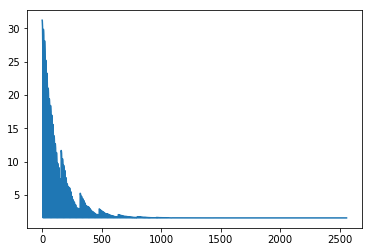

In [57]:
plt.plot(o*10)

In [52]:
# Read in TESS Sector data
print("Reading TESS data...")
sector_name = "Sector{}".format(sector)
if sector == 0:
    sector_name = "sample_"+sector_name
sector_path = p.join(tess_dir, sector_name)
sector_files = glob.glob(p.join(sector_path,"*.fits"))
tess_names = sector_files[start:end]
ntess = len(tess_names)
print("Found {} TESS files to process".format(ntess))

# Read in Batman Curves 
print("Reading Batman transit curves...")
batmanCurves = ascii.read(p.join(batman_dir,"batmanCurves_small.csv"), 
                   data_start=1, format='csv')
times = np.array(batmanCurves['times'])
curve_names = np.array(batmanCurves.colnames[1:])
nbatman = len(curve_names)
print("Found {} Batman curves".format(nbatman))

nerr = 0  # count number of failed files
# Do convolution on all tess files
tess_fpath = tess_names[0]
tess_fname = p.basename(tess_fpath)
print("Starting TESS file: {}".format(tess_fname))
tess_start = time.time()

try:
    with fits.open(tess_fpath, mode="readonly") as hdulist:
        hdr = hdulist[0].header
        tess_time = hdulist[1].data['TIME']
        tess_flux = hdulist[1].data['PDCSAP_FLUX']
except Exception as e: 
    print("ERROR reading file: ", tess_fpath, " with error: ", e)
    nerr += 1
    #continue  # skip to next loop iter

# clean tess lightcurve of nans
med = np.nanmedian(tess_flux)
tess_flux[np.isnan(tess_flux)] = med

tmean = np.mean(tess_flux)
tstd = np.std(tess_flux)
tess_flux = (tess_flux - tmean)/tstd
# Do convolution on each batman curve
max_array=np.zeros(nbatman)
tmax_array=np.zeros(nbatman)
conv_start = time.time()
print("Starting convolutions...")
j = 150
curvename = curve_names[j]
batman_flux = batmanCurves[curvename]
convolution = np.abs(np.convolve(tess_flux, batman_flux, 'same'))
ind_max = np.argmax(convolution)
conv_max = convolution[ind_max]
label = "{}, Convolution: {}".format(curvename, conv_max)
print(label)

Reading TESS data...
Found 5 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: tess2018263035959-s0003-0000000003836541-0123-s_lc.fits
Starting convolutions...
curve 150, Convolution: 133.0316048006697


In [28]:
batman_flux_nopad = batmanCurves[curvename]
len_diff = len(tess_time)-len(batman_flux_nopad)
batman_flux = np.pad(batman_flux_nopad, (len_diff, 0), 'constant', constant_values=(1,1))      
batman_FFT=np.fft.fft(batman_flux)
tess_FFT=np.fft.fft(tess_flux)
convolution2=(np.absolute(np.fft.ifft((batman_FFT)*(tess_FFT))))

Text(0.5, 1.0, 'curve 150, Convolution: 133.0316048006697')

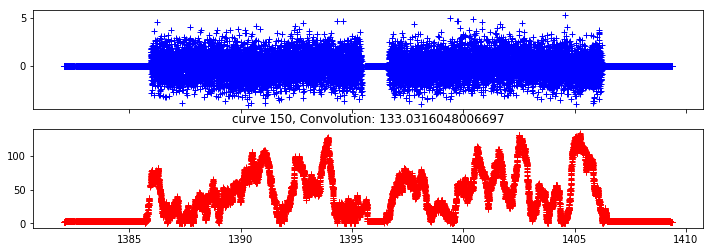

In [53]:
fix, ax = plt.subplots(2, sharex=True, figsize=(12, 4))
ax[0].plot(tess_time,tess_flux, 'b+')
ax[1].plot(tess_time,convolution, 'r+')
plt.title(label)

Text(0.5, 1.0, 'curve 1, Convolution: 131.32612690588854')

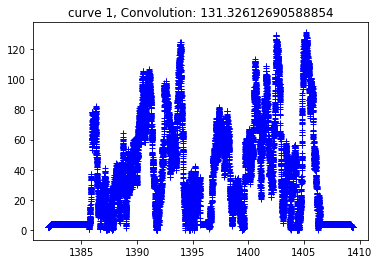

In [37]:
plt.plot(tess_time,convolution, 'b+')


Pct: 119.31523032314423 Count: 66


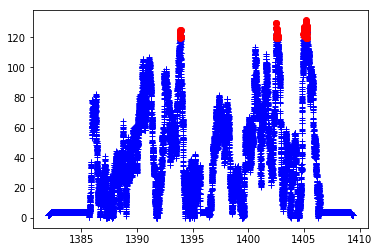

In [26]:
import scipy as sp
pct=np.percentile(convolution, 99)
peaks,props=sp.signal.find_peaks(convolution,height=pct)
print("Pct:",pct, "Count:",len(peaks))
plt.plot(tess_time,convolution, 'b+')
plt.plot(tess_time[peaks],convolution[peaks], 'ro')

In [184]:
a = [1,2,3]
print(a[:1000])

[1, 2, 3]
